# ACTIVITY: A CLASSIFIER

The goal of this activity is to practice building and discussing a classifier. By the end of the activity, you should be able to justify your design decisions according to 

TASK:

In [1]:
import kagglehub
import os
import pandas as pd
from pathlib import Path

path = kagglehub.dataset_download("hgultekin/bbcnewsarchive")
print(os.listdir(path))
df = pd.read_csv(Path(path) / "bbc-news-data.csv", sep='\t')

100%|██████████| 1.81M/1.81M [00:00<00:00, 2.74MB/s]

Extracting files...


['bbc-news-data.csv']


In [2]:
df.head()

,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...


## Baseline classifier

We will start with a baseline classifier. It is a simple Bag-of-words classifier.

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(df['content'], df['category'], test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(max_iter=1000))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

               precision    recall  f1-score   support

     business       0.95      0.97      0.96       115
entertainment       0.97      0.94      0.96        72
     politics       0.96      0.95      0.95        76
        sport       0.99      0.99      0.99       102
         tech       0.95      0.95      0.95        80

     accuracy                           0.96       445
    macro avg       0.96      0.96      0.96       445
 weighted avg       0.96      0.96      0.96       445



## PART 1: preparation

Answer the questions below as comments in the following cell. In your answers, avoid using common sense. Use adequate jargons.

In [ ]:
#ex1

# Question 1: What is the underlying premise of the Bag-of-Words classifier, that is, why does BoW allow to classify these texts?
# Question 2: What is the underlying premise of a BERT-based classifier, that is, why should BERT embeddings be interesting to classify these texts?


# **Question 1**

The premise of a Bag-of-words classifier is to represent each document as a vector based on the words present (or not) in that document, such as the Tfidf. The idea is that a certain class of documents can be classified by that vector. It does not take into consideration the position or order of the words, that is why it is called Bag of Words. The advantage of this approach is being a very simple-to-implement baseline before considering other, more intricate approaches. However, the lack of considering the position and context of the words can lead to not so good results. The explicability of this model is another important factor: using a Bag-of-Words model with a Linear Regressor as the final step of the model allows us to know clearly what are the assigned weights to each one of the words in our vocabulary, something lost with Deep Learning techniques.

# **Question 2**

The premise of a BERT-based classifier is utilizing the BERT embeddings to represent each document. Embeddings also represent each document as a vector, but they take into consideration the position of each word in the text, adding the idea of context to the representation. The advantage of this approach is that it can capture the meaning of the words in a more sophisticated way, leading to better results in many cases. However, the disadvantage is that it is much more complex to implement and requires more computational resources. The explicability of this model is also a concern: while we can still analyze the embeddings, it is not as straightforward as with a Bag-of-Words model. Besides that, using pre-trained BERT embeddings can also limit the model to the knowledge contained in the pre-trained model, which may not be sufficient for some tasks.

## PART 2: action

(a) Make a classifier that uses BERT embeddings to categorize the texts in the dataset we have discussed.

(b) Make a bar plot comparing the accuracy of the BERT-based classifier to that of the Bag-of-Words classifier

(c) Use a PCA or a T-SNE plot to visualize the documents in the newsgroups dataset in the embedding space provided by BERT. Analyze the plot taking into account the confusion matrix or the classification report of your BERT-based classifier.




In [4]:
#ex2
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained("bert-base-uncased")

In [6]:
from tqdm import tqdm
import numpy as np

X_embeddings = []
for text in tqdm(df['content'].values):
    encoded_input = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
    output = model(**encoded_input)
    X_embeddings.append(output.last_hidden_state[0, 0, :].detach().numpy())

X_embeddings = np.array(X_embeddings)

100%|██████████| 2225/2225 [10:53<00:00,  3.40it/s]


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_embeddings, df['category'], test_size=0.2, random_state=42)

# Create a pipeline with TfidfVectorizer and LogisticRegression
model = LogisticRegression(max_iter=1000)

# Train the pipeline
model.fit(X_train, y_train)

# Test the pipeline
y_pred = model.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))

               precision    recall  f1-score   support

     business       0.97      0.96      0.96       115
entertainment       0.97      0.97      0.97        72
     politics       0.95      0.97      0.96        76
        sport       1.00      0.99      1.00       102
         tech       0.96      0.97      0.97        80

     accuracy                           0.97       445
    macro avg       0.97      0.97      0.97       445
 weighted avg       0.97      0.97      0.97       445



/tmp/ipykernel_6895/2598208459.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_embeddings = torch.tensor(X_embeddings)


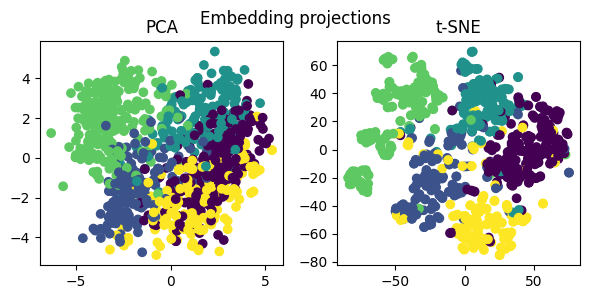

In [14]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torch

# Transform X_embbedings to torch tensor
X_embeddings = torch.tensor(X_embeddings)

indices = torch.randperm(X_embeddings.size(0))[:1000]
embeddings_post = X_embeddings[indices]
y_sample = df['category'].iloc[indices]

pca = PCA(n_components=2)
embeddings_post_pca = pca.fit_transform(embeddings_post)
tsne = TSNE(n_components=2, perplexity=5)
embeddings_post_tsne = tsne.fit_transform(embeddings_post)
plt.figure(figsize=(6, 3))
plt.subplot(1,2,1)
plt.scatter(embeddings_post_pca[:,0], embeddings_post_pca[:,1], c=y_sample.astype('category').cat.codes)
plt.title("PCA")
plt.subplot(1,2,2)
plt.scatter(embeddings_post_tsne[:,0], embeddings_post_tsne[:,1], c=y_sample.astype('category').cat.codes)
plt.title("t-SNE")
plt.tight_layout()
plt.suptitle("Embedding projections")
plt.show()